In [1]:
import time
import gc
import torch
import numpy as np
import pandas as pd

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, precision_score


In [ ]:
dataset = load_dataset("stanfordnlp/imdb")

test_data = dataset["test"].shuffle(seed=42).select(range(300))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [ ]:
print(test_data)

Dataset({
    features: ['text', 'label'],
    num_rows: 300
})


In [ ]:
def evaluate_model(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    model.eval()

    texts = test_data["text"]
    labels = test_data["label"]

    preds = []
    start_time = time.time()

    with torch.no_grad():
        for text in texts:
            inputs = tokenizer(
                text,
                truncation=True,
                padding="max_length",
                max_length=128,
                return_tensors="pt"
            )
            outputs = model(**inputs)
            preds.append(torch.argmax(outputs.logits, dim=1).item())

    avg_time = (time.time() - start_time) / len(texts)

    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    precision = precision_score(labels, preds)

    model_size = sum(p.numel() for p in model.parameters()) * 4 / (1024**2)

    del model, tokenizer
    gc.collect()
    torch.cuda.empty_cache()

    return accuracy, f1, precision, avg_time * 1000, model_size


In [ ]:
results = []

models = [
    ("BERT", "bert-base-uncased"),
    ("DistilBERT", "distilbert-base-uncased"),
    ("ALBERT", "albert-base-v2"),
    ("ELECTRA", "google/electra-base-discriminator"),
    ("RoBERTa", "roberta-base")
]
for name, model_id in models:
    print(f"\nEvaluating {name}...")

    try:
        metrics = evaluate_model(model_id)
        results.append([name, *metrics])
        print(f"{name} done")

    except Exception as e:
        print(f"{name} failed ")
        print(e)

    # HARD CLEANUP (critical for Python 3.13)
    gc.collect()
    torch.cuda.empty_cache()


Evaluating BERT...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT done

Evaluating DistilBERT...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBERT done

Evaluating ALBERT...


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ALBERT done

Evaluating ELECTRA...


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ELECTRA done

Evaluating RoBERTa...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RoBERTa done


In [ ]:
decision_matrix = pd.DataFrame(
    results,
    columns=[
        "Model",
        "Accuracy",
        "F1-score",
        "Precision",
        "Inference Time (ms)",
        "Model Size (MB)"
    ]
)

decision_matrix


,Model,Accuracy,F1-score,Precision,Inference Time (ms),Model Size (MB)
0,BERT,0.496667,0.025806,0.400000,519.720859,417.647469
1,DistilBERT,0.506667,0.026316,1.000000,246.064145,255.413094
2,ALBERT,0.483333,0.645309,0.491289,550.528887,44.575203
3,ELECTRA,0.496667,0.654462,0.498258,494.411416,417.647469
4,RoBERTa,0.490000,0.231156,0.469388,495.341160,475.491219


In [ ]:
decision_matrix.to_csv("decision_matrix.csv", index=False)

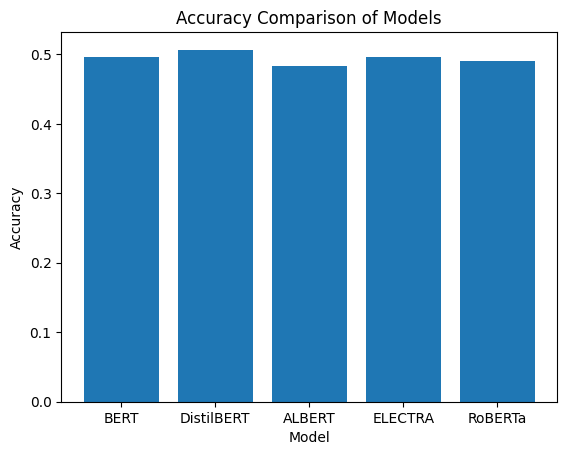

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(decision_matrix["Model"], decision_matrix["Accuracy"])
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison of Models")
plt.show()


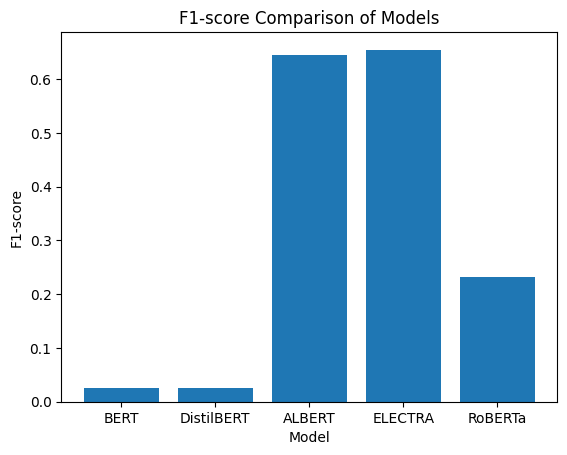

In [ ]:
plt.figure()
plt.bar(decision_matrix["Model"], decision_matrix["F1-score"])
plt.xlabel("Model")
plt.ylabel("F1-score")
plt.title("F1-score Comparison of Models")
plt.show()


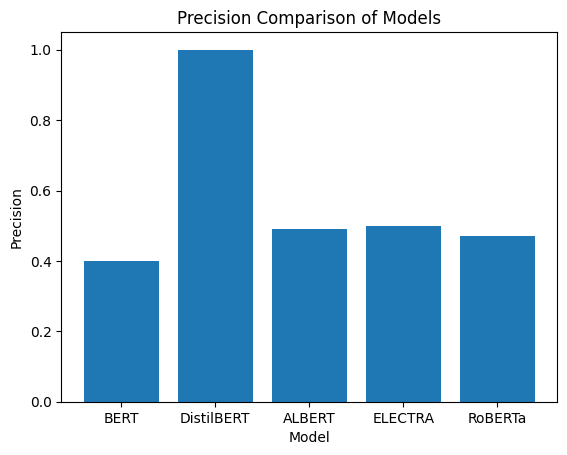

In [ ]:
plt.figure()
plt.bar(decision_matrix["Model"], decision_matrix["Precision"])
plt.xlabel("Model")
plt.ylabel("Precision")
plt.title("Precision Comparison of Models")
plt.show()


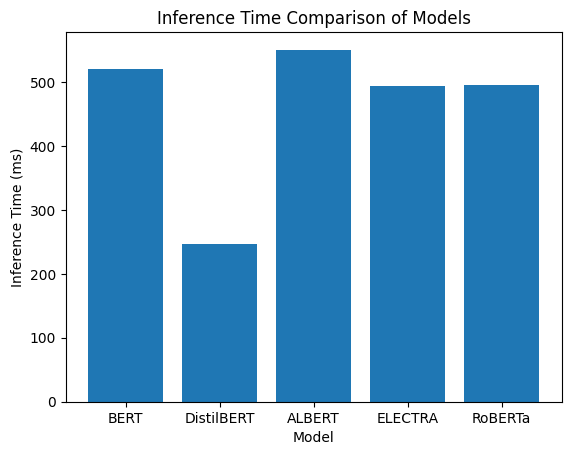

In [ ]:
plt.figure()
plt.bar(decision_matrix["Model"], decision_matrix["Inference Time (ms)"])
plt.xlabel("Model")
plt.ylabel("Inference Time (ms)")
plt.title("Inference Time Comparison of Models")
plt.show()


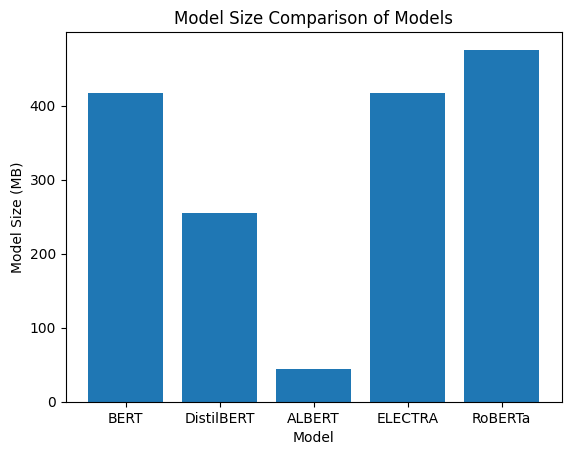

In [ ]:
plt.figure()
plt.bar(decision_matrix["Model"], decision_matrix["Model Size (MB)"])
plt.xlabel("Model")
plt.ylabel("Model Size (MB)")
plt.title("Model Size Comparison of Models")
plt.show()
